# Submitted By : (GROUP - 15)

Shailesh Chaudhary - 22CS60R37

Kamal Kyal - 19CE10035

Rishi Suman - 19EC39045

# [ Project Code: MPDT ]
# Car Manufacturer Prediction using Decision Tree based Learning Model

## Import required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import graphviz
from sklearn.metrics import classification_report
import csv
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree


In [2]:
# Loading the dataset
df = pd.read_csv('cars.csv')
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [3]:
# Extarcting dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  261 non-null    object 
 3    hp           261 non-null    int64  
 4    weightlbs    261 non-null    object 
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 16.4+ KB


In [4]:
#Removing empty space from the cubicinches
mode_cubic = df[" cubicinches"].describe()['top']
df.replace(" ", mode_cubic, inplace=True)
df[df[" cubicinches"]==" "]

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand


In [5]:
#converting cubicinches and weightlbs from object to int
df[" cubicinches"] = pd.to_numeric(df[" cubicinches"])
df[" weightlbs"] = pd.to_numeric(df[" weightlbs"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  261 non-null    int64  
 3    hp           261 non-null    int64  
 4    weightlbs    261 non-null    int64  
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 16.4+ KB


In [6]:
#finding number of column in our dataset
df.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

In [7]:
#finding row and column diamension of our dataset
df.shape

(261, 8)

In [8]:
# Calculating NULL percentage in each feature
((df.isnull().sum() / len(df))*100).sort_values(ascending=False).to_frame()
# This shows that there are no null values in the dataset for any feature

,0
mpg,0.0
cylinders,0.0
cubicinches,0.0
hp,0.0
weightlbs,0.0
time-to-60,0.0
year,0.0
brand,0.0


C:\Users\user\AppData\Local\Temp\ipykernel_9512\1990556348.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<AxesSubplot: >

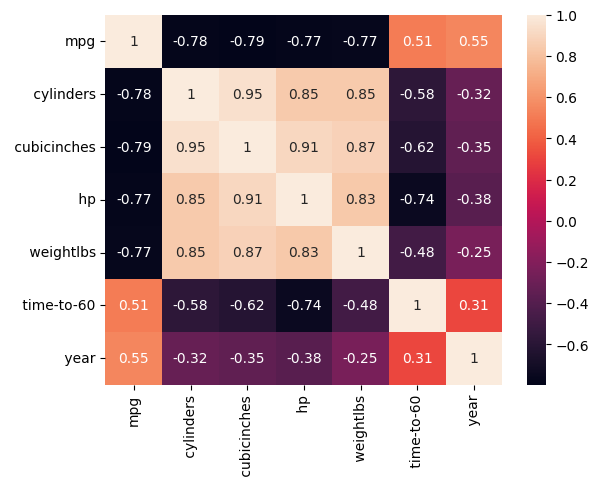

In [9]:
# Plotting heatmap to see correlation between features
sns.heatmap(df.corr(),annot=True)

In [10]:
# reset the indices of df 
# It will help in partitioning the dataset further
df = df.reset_index(drop=True)

In [11]:
df.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

In [12]:
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [13]:
df[" brand"].value_counts()

 US.        162
 Japan.      51
 Europe.     48
Name:  brand, dtype: int64

In [14]:
# converting the class value US->0,Europe->1 Japan->
df[" brand"] =df[" brand"].map({" US.":0," Europe.":1," Japan.":2})

In [15]:
# Randomize the order of rows in dataset
df = df.reindex(np.random.permutation(df.index)) 
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
158,19.0,6,232,100,2634,13,1972,0
26,31.0,4,71,65,1773,19,1972,2
204,21.0,4,140,72,2401,20,1974,0
14,19.1,6,225,90,97,19,1981,0
94,26.0,4,98,79,2255,18,1977,0


# Task 1 - Five fold cross validation
The dataset is not divided into train and validation sets.
The first task is to randomly partition the complete dataset into 5 parts: assign the first
part as validation set and the rest for training the model. Repeat the process 5 times,
assigning the validation sets in a round robin manner

In [16]:
# we have total 768 rows so, we need to divide them into 5 parts
# 4 parts will have 52 records in it and 1 part will have 53 records
fold1 = df[0:52]
fold2 = df[52:104]
fold3 = df[104:156]
fold4 = df[156:208]
fold5 = df[208:261]

print(fold1.shape,fold2.shape,fold3.shape,fold4.shape,fold5.shape)

(52, 8) (52, 8) (52, 8) (52, 8) (53, 8)


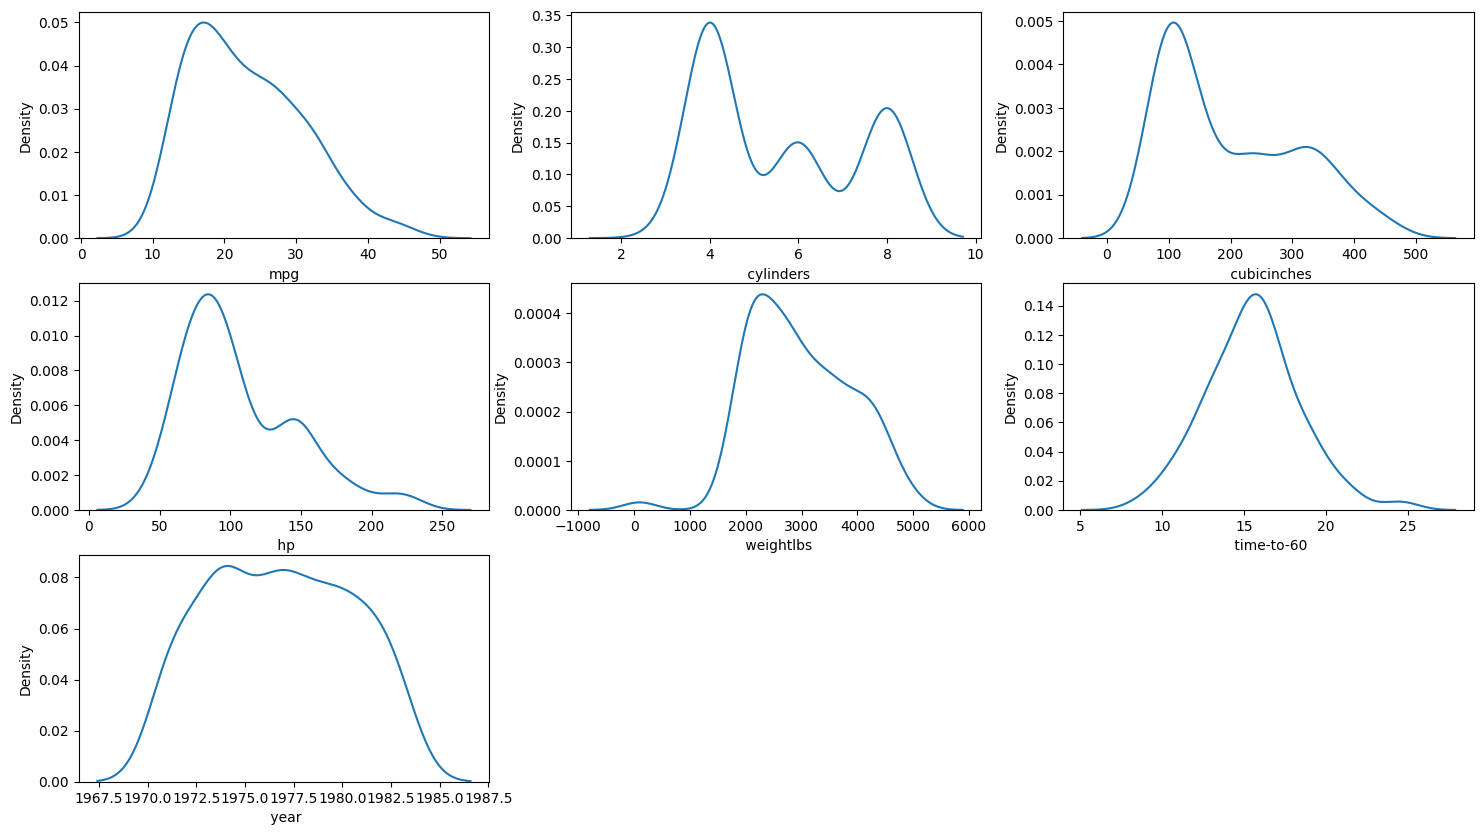

In [17]:
# Plotting the distribution of feature
column_list = df.columns.to_list()[:-1]
plt.figure(figsize=(18,10))
for i in enumerate(column_list):
    plt.subplot(3,3,i[0]+1)
    sns.kdeplot(df[i[1]])
    
# As we can see that some of them have almost Guassian distribution and some has skewed distribution

In [18]:
# number of different classes to predict
n_classes = np.unique(df[' brand'])
n_classes

array([0, 1, 2], dtype=int64)

In [19]:
df[' brand'].value_counts()

0    162
2     51
1     48
Name:  brand, dtype: int64

In [20]:
# create train and test dataset from the 5-fold created earlier by merging in round-robin manner
train_val1 = pd.concat([fold1, fold2, fold3, fold4])
test_val1 = fold5

train_val2 = pd.concat([fold1, fold2, fold3, fold5])
test_val2 = fold4

train_val3 = pd.concat([fold1, fold2, fold4, fold5])
test_val3 = fold3

train_val4 = pd.concat([fold1, fold3, fold4, fold5])
test_val4 = fold2

train_val5 = pd.concat([fold2, fold3, fold4, fold5])
test_val5 = fold1

In [21]:
# Removing last class attribute from dataset for applying classification
features = df.columns.to_list()
features = features[:-1]
features

['mpg',
 ' cylinders',
 ' cubicinches',
 ' hp',
 ' weightlbs',
 ' time-to-60',
 ' year']

# Task 2(a) - Implement the classifier
a. Implement the Decision Tree classifier as stated in the Objective
Statement.

b. Train and test your implementation on the data provided in the dataset.

c. Compare the results with the results obtained from the Decision Tree
classifier of scikit-learn package.

In [22]:
# CREATION OF NODE OF DECISION TREE
class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        #If a leaf node
        self.value = value
        self.id=None
    
    def format_string(self):
        if self.feature is None:
            return "None"
        return features[self.feature] + "->" + str(self.threshold)
        

In [23]:
# DECISION TREE IMPLEMENTATION
class DecisionTree():

    def __init__(self, min_samples=2, max_depth=2):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.root=None
        self.id=None
        
    def split_data(self, dataset, feature, threshold):
        #create left, right datasets as empty arrays
        left_dataset = []
        right_dataset = []
        # loop over each row in the dataset
        for row in dataset:
            if row[feature] <= threshold: # compare row to threshold
                left_dataset.append(row)
            else:
                right_dataset.append(row)
        # convert left, right datasets to numpy arrays
        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    #### FINDING ENTROPY #########
    
    def entropy(self, y):
        entropy = 0
        # find unique values in y
        labels = np.unique(y)
        # loop over each unique value
        for label in labels:
            # find elements in y that are equal to that label
            label_examples = y[y == label]
            # get ratio of the label
            pl = len(label_examples) / len(y)
            # calculate entropy
            entropy += -pl * np.log2(pl)
        return entropy
    
    ######### CALCULATION OF INFORMATION GAIN ######
    
    def information_gain(self, parent, left, right):
        # set initial information gain to 0
        information_gain = 0
        # compute entropy for parent
        parent_entropy = self.entropy(parent)
        # calculate weight for left and right nodes
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        # compute entropy for left and right nodes
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        # calculate weighted entropy 
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        # calculate information gain 
        information_gain = parent_entropy - weighted_entropy
        return information_gain

    ########## FINDING BEST SPLIT############
    
    def best_split(self, dataset, num_samples, num_features):
        # dictionary to store the best split values
        best_split = {'gain':- 1, 'feature': None, 'threshold': None}
        # loop over all the features
        for feature_index in range(num_features):
            #get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            #get unique values of that feature
            thresholds = np.unique(feature_values)
            # loop over all values of the featurre
            for threshold in thresholds:
                # get left and right datasetss
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                # check if either datasets is empty
                if len(left_dataset) and len(right_dataset):
                    # get y values of the parent and left, right nodes
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    # compute information gain based on the y values
                    information_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if conditions are met
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split
    
    ### CALCULATION FOR LEAF NODE ####
    
    def calculate_leaf_value(self, y):
        #Convert y to list
        y = list(y)
        #get the highest present class in the array
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value

    #### BUILDING DECISION TREE ######
    
    def build_tree(self, dataset, current_depth=0):
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        # keeps spliting until stopping conditions are met
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            # Get the best split
            best_split = self.best_split(dataset, n_samples, n_features)
            # Check if gain isn't zero
            if best_split["gain"]:
                ### DO SPLITTING AT DIFFERENT DEPTH ####
                
                # continue splitting the left and the right child. Increment current depth
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                # return decision node
                return Node(best_split["feature"], best_split["threshold"],
                            left_node, right_node, best_split["gain"])

        # compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        # return leaf node value
        return Node(value=leaf_value)

    
    def fit(self, X, y):
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self.build_tree(dataset)
        return self.root

    
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.make_prediction(x, self.root)
            predictions.append(prediction)
        # np.array(predictions)
        return predictions
     
    def make_prediction(self, x, node):
        # if the node has value i.e it's a leaf node extract it's value
        if node.value != None: 
            return node.value
        else:
            #if it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)

In [24]:
X = df[features].values
y = df[' brand'].values.reshape(-1,1)


# Task 2(b) - Without pruning Decision tree report for 5 train-test data in round robin manner

Test the implementation of Decision Tree Classifier from scikit-learn package,
using information gain (code snippet provided).


In [25]:
# CONFUSION MATRIX CALCULATION CODE FOR 3 CLASS VALUE
def three_class_confusion_matrix(y_true, y_pred):
    cm = np.zeros((3, 3), dtype=int)
    for i in range(len(y_true)):
        cm[y_pred[i]][y_true[i]] += 1
    return cm



def calculate_metrics(cm):
    precision = np.zeros(cm.shape[0])
    recall = np.zeros(cm.shape[0])
    accuracy = 0
    f1_score = np.zeros(cm.shape[0])
   
    for i in range(cm.shape[0]):
        precision[i] = cm[i][i] / sum(cm[:, i])
        recall[i] = cm[i][i] / sum(cm[i, :])
        accuracy += cm[i][i]
    accuracy /= np.sum(cm)
   
    for i in range(cm.shape[0]):
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
       
    return [precision, recall, accuracy, f1_score]

In [26]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
accuracies = []

X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float('inf')) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)
# print(f" Our model's Accuracy: {accuracy_score(y_test, predictions)}")
# print(f"Our model's Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}")

# ######### PRINTING REPORT OF FOLD 1 #########
# print("\t  Precision \t\t Recall \t\t f1_score")
# print("US ", " \t", mat_list[0][0], "\t", mat_list[1][0], "\t\t", mat_list[3][0]) 
# print("Japan ", " ", mat_list[0][1], "\t", mat_list[1][1],"\t", mat_list[3][1]) 
# print("Europe ", " ", mat_list[0][2], "\t", mat_list[1][2],"\t", mat_list[3][2]) 
# # print("Accuracy ",mat_list[2])

# Printing report

print("\t\t\t\t FOLD - 1\n")
print(classification_report(y_test, y_pred))

# storing accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracies.append(report['accuracy'])


# FOLD 2

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val2[features].values
X_test = test_val2[features].values

y_train = train_val2[' brand'].values.reshape(-1,1)
y_test = test_val2[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float('inf')) #create model instance
modelroot = model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val2[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t\t\t FOLD - 2\n")
print(classification_report(y_test, y_pred))

# storing accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracies.append(report['accuracy'])

# FOLD-3

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val3[features].values
X_test = test_val3[features].values

y_train = train_val3[' brand'].values.reshape(-1,1)
y_test = test_val3[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float('inf')) #create model instance
model.fit(X_train,y_train) # fit the model to the training data


# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val3[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t\t\t FOLD - 3\n")
print(classification_report(y_test, y_pred))

# storing accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracies.append(report['accuracy'])

# FOLD 4

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val4[features].values
X_test = test_val4[features].values

y_train = train_val4[' brand'].values.reshape(-1,1)
y_test = test_val4[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float('inf')) #create model instance
model.fit(X_train,y_train) # fit the model to the training data


# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val4[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t\t\t FOLD - 4\n")
print(classification_report(y_test, y_pred))

# storing accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracies.append(report['accuracy'])

# FOLD 5

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val5[features].values
X_test = test_val5[features].values

y_train = train_val5[' brand'].values.reshape(-1,1)
y_test = test_val5[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float('inf')) #create model instance
model.fit(X_train,y_train) # fit the model to the training data


# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val5[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t\t\t FOLD - 5\n")
print(classification_report(y_test, y_pred))

# storing accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracies.append(report['accuracy'])

# print(accuracies)



				 FOLD - 1

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.67      0.80      0.73         5
           2       1.00      0.62      0.77         8

    accuracy                           0.89        53
   macro avg       0.86      0.79      0.81        53
weighted avg       0.90      0.89      0.88        53

				 FOLD - 2

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       1.00      0.58      0.74        12
           2       0.67      0.92      0.77        13

    accuracy                           0.81        52
   macro avg       0.84      0.79      0.79        52
weighted avg       0.84      0.81      0.81        52

				 FOLD - 3

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.43      0.27      0.33        11
           2       0.64      0

In [27]:
# # Function to print decision tree using DFS
# def print2DTree(root, space=0, LEVEL_SPACE = 5):
#         # root=self.root
#         if (root == None): return
#         space += LEVEL_SPACE
#         print2DTree(root.right, space)
#         # print() # neighbor space
#         for i in range(LEVEL_SPACE, space): print(end = " ")  
#         print("\t|" + root.format_string() + "|<")
#         print2DTree(root.left, space)

In [28]:
# import math

# def t2_lvl(   i):  return int(math.log2(i+1)) if 0<i else 0  # @meta  map the global idx to the lvl
# def t2_i2base(i):  return (1<<t2_lvl(i))-1                   # @meta  map the global idx to the local idx (ie. the idx of elem 0 in the lvl at idx @i)
# def t2_l2base(l):  return (1<<       l) -1                   # @meta  map the lvl        to the local idx (ie. the idx of elem 0 in lvl @l)

# def t2_show(tree):  # @meta  2-pass fn. in the 1st pass we compute the height
#     if not tree:  return
#     q0 = []  # perm queue
#     q1 = []  # temp queue

#     # pass 0
#     h = 0  # height is the number of lvls
#     q0.append((tree,0))
#     q1.append((tree,0))
#     while q1:
#         n,i = q1.pop(0)
#         h = max(h, t2_lvl(i))
#         if n.left:  l=(n.left, 2*i+1); q0.append(l); q1.append(l)
#         if n.right:  r=(n.right, 2*i+2); q0.append(r); q1.append(r)
#     h += 1         # nlvls
#     N  = 2**h - 1  # nelems (for a perfect tree of this height)
#     W  = 1         # elem width

#     # pass 1
#     print(f'\n\x1b[31m{h} \x1b[32m{len(q0)}\x1b[0m')
#     print(f'{0:1x}\x1b[91m:\x1b[0m',end='')
#     for idx,(n,i) in enumerate(q0):
#         l  = t2_lvl(i)  # lvl
#         b  = (1<<l)-1   # base
#         s0 = (N // (2**(l+1)))
#         s1 = (N // (2**(l+0)))
#         s  = 3+1 + s0 + (i-b)*(s1+1)  # absolute 1-based position (from the beginning of line)
#         w  = int(2**(h-l-2))          # width (around the element) (to draw the surrounding @-)

#         # print(f'{i:2x} {l} {i-b}  {s0:2x} {s1:2x} {s:2x} {w:x}  {n.v:02x}')
#         if 0<idx and t2_lvl(q0[idx-1][1])!=l:  print(f'\n{l:1x}\x1b[91m:\x1b[0m',end='')  # new level: go to the next line
#         print(f"\x1b[{s-w}G{w*'-'}\x1b[1G", end='')
#         print(f"\x1b[{s}G{n.v:1x}\x1b[1G",  end='')  # `\x1b[XG` is an ANSI escape code that moves the cursor to column X
#         print(f"\x1b[{s+W}G{w*'-'}\x1b[1G", end='')
#     print()

# Comparission of with sklearn library

In [29]:
import csv
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np

sk_accuracies=[]

# read csv file into list and convert elements to int/float
with open('cars.csv', 'r') as read_obj:
	csv_reader = csv.reader(read_obj)
	str_data = list(csv_reader)[1:]
	dataset = []
	for i in range(len(str_data)):
		if len(str_data[i])!=8:
			continue
			
		if str_data[i][7]==' US.':
			str_data[i][7] = 0
		elif str_data[i][7]==' Japan.':
			str_data[i][7] = 1
		elif str_data[i][7]==' Europe.':
			str_data[i][7] = 2
		
		try:
			temp = list(map(float, str_data[i][:7]))
			temp.append(str_data[i][7])
			dataset.append(temp)
		except:
			print(str_data[i])

# Separate labels and features for each data item
# print(dataset[:5])
X, y = [row[:7] for row in dataset], [row[7] for row in dataset]

# create 5 fold cross validation set (n_splits=5)
rn = range(1, len(dataset))
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)

# traverse over each split
for train_index, test_index in kf5.split(rn):
	# print(train_index, test_index)
	X_train, X_test = np.array([X[i] for i in train_index]), np.array([X[i] for i in test_index])
	y_train, y_test = np.array([y[i] for i in train_index]), np.array([y[i] for i in test_index])
	
	# Save the datasets to file to process it from file separately
	
	# create decision tree using the sklearn library
	clf = DecisionTreeClassifier()
	# more at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
	y_pred = clf.fit(X_train, y_train).predict(X_test)
	print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=['US', 'Japan', 'Europe']))
	# storing accuracy
	report = classification_report(y_test, y_pred, output_dict=True)
	sk_accuracies.append(report['accuracy'])
    

# print(sk_accuracies)


['19.1', '6', '225', '90', ' ', '19', '1981', 0]
['21', '6', '199', '90', ' ', '15', '1971', 0]
['16', '6', ' ', '105', '3897', '19', '1976', 0]
['29', '4', '68', '49', ' ', '20', '1974', 2]
['19.8', '6', ' ', '85', '2990', '18', '1980', 0]
              precision    recall  f1-score   support

          US       0.94      0.89      0.91        35
       Japan       0.36      0.80      0.50         5
      Europe       0.71      0.45      0.56        11

    accuracy                           0.78        51
   macro avg       0.67      0.71      0.66        51
weighted avg       0.83      0.78      0.79        51

              precision    recall  f1-score   support

          US       0.90      0.93      0.92        30
       Japan       0.73      0.62      0.67        13
      Europe       0.56      0.62      0.59         8

    accuracy                           0.80        51
   macro avg       0.73      0.72      0.72        51
weighted avg       0.80      0.80      0.80        5

# Comparision of scrach Model vs Sklearn Model

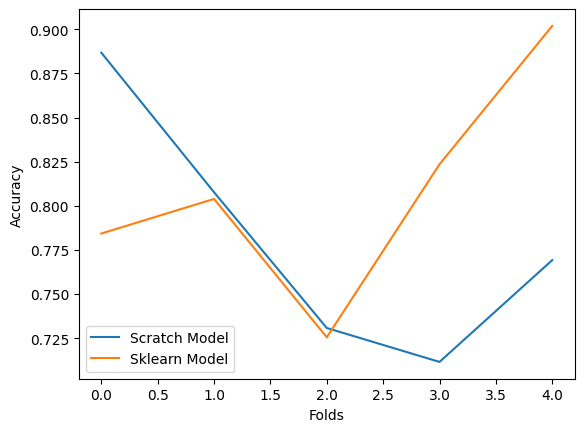

In [30]:
sns.lineplot(x=range(len(accuracies)), y=accuracies, label="Scratch Model")
sns.lineplot(x=range(len(sk_accuracies)), y=sk_accuracies, label="Sklearn Model")

# Add labels and title
plt.ylabel("Accuracy")
plt.xlabel("Folds")
# Show plot
plt.show()

# Task - 3: Reduced Pruning 

In [31]:
# PRUNING AT DEFPTH OF 5

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float(5)) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t PRUNING AT DEPTH : 5\n")
print(classification_report(y_test, y_pred))

# PRUNING AT DEFPTH OF 10

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float(10)) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t PRUNING AT DEPTH : 10\n")
print(classification_report(y_test, y_pred))

# PRUNING AT DEFPTH OF 15

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float(15)) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report

print("\t\t PRUNING AT DEPTH : 15\n")
print(classification_report(y_test, y_pred))

# PRUNING AT DEFPTH OF 20

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float(20)) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

# Printing report
print("\t\t PRUNING AT DEPTH : 20\n")
print(classification_report(y_test, y_pred))

# PRUNING AT DEFPTH OF 25

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)
X_train = train_val1[features].values
X_test = test_val1[features].values

y_train = train_val1[' brand'].values.reshape(-1,1)
y_test = test_val1[' brand'].values.reshape(-1,1)

model = DecisionTree(2, float(25)) #create model instance
model.fit(X_train,y_train) # fit the model to the training data

# # get the accuracy score
# from sklearn.metrics import accuracy_score,balanced_accuracy_score
y_pred = model.predict(X_test) #evaluate the model on the test data
y_pred = [int(a) for a in y_pred]
cm = three_class_confusion_matrix(test_val1[' brand'].to_list(), y_pred)
mat_list=calculate_metrics(cm)

print("\t\t PRUNING AT DEPTH : 25\n")
print(classification_report(y_test, y_pred))

		 PRUNING AT DEPTH : 5

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       0.67      0.80      0.73         5
           2       0.83      0.62      0.71         8

    accuracy                           0.89        53
   macro avg       0.81      0.79      0.79        53
weighted avg       0.89      0.89      0.88        53

		 PRUNING AT DEPTH : 10

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.67      0.80      0.73         5
           2       1.00      0.62      0.77         8

    accuracy                           0.89        53
   macro avg       0.86      0.79      0.81        53
weighted avg       0.90      0.89      0.88        53

		 PRUNING AT DEPTH : 15

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.67      0.80      0.73         